In [44]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt

In [70]:
# matrix representation of fredkin gate
U = np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1]])
print(U)

[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]]


In [79]:
dev = qml.device("default.qubit.autograd", wires=3)


#@qml.qnode(dev)
def ansatz(params):
    l=params
    #H=Z⊗Z⊗I
    qml.CNOT(wires=[0,1])
    qml.RZ(l[0],wires=1)
    qml.CNOT(wires=[0,1])

    # circuit for local ham H=I⊗Z⊗Z
    qml.CNOT(wires=[1,2])
    qml.RZ(l[1],wires=2)
    qml.CNOT(wires=[1,2])
    
    
    # circuit for local ham H=Z⊗I⊗Z
    qml.CNOT(wires=[0,2])
    qml.RZ(l[2],wires=2)
    qml.CNOT(wires=[0,2])
    
    qml.RZ(l[3],wires=0)

    # circuit for local ham H=X⊗X⊗I  
    [qml.Hadamard(wires=i) for i in range(0,2)]
    qml.CNOT(wires=[0,1])
    qml.RZ(l[4],wires=1)
    qml.CNOT(wires=[0,1])
    [qml.Hadamard(wires=i) for i in range(0,2)]
    
    # circuit for local ham H=X⊗I⊗X
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=2)
    qml.CNOT(wires=[0,2])
    qml.RZ(l[5],wires=2)
    qml.CNOT(wires=[0,2])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=2)
    
    # circuit for local ham H=I⊗X⊗X
    [qml.Hadamard(wires=i) for i in range(1,3)]
    qml.CNOT(wires=[1,2])
    qml.RZ(l[6],wires=2)
    qml.CNOT(wires=[1,2])
    [qml.Hadamard(wires=i) for i in range(1,3)]
    
    #[qml.Hadamard(wires=i) for i in range(1,3)]
 


    # circuit for local ham H=I⊗Y⊗Y
    [qml.RX(np.pi/2,wires=i) for i in range(1,3)]
    qml.CNOT(wires=[1,2])
    qml.RZ(l[7],wires=2)
    qml.CNOT(wires=[1,2])
    [qml.RX(-np.pi/2,wires=i) for i in range(1,3)]


    qml.RX(l[8],wires=2)
    qml.RX(l[9],wires=1)

In [80]:
@qml.qnode(dev, diff_method="backprop")
def circuit(params, state, apply_inv=True):
    qml.BasisState(np.array(state), wires=[0,1,2])
  
    ansatz(params[:10])
    ansatz(params[:10])
    ansatz(params[:10])
    ansatz(params[:10])
    ansatz(params[:10])
    ansatz(params[:10])
    
    return qml.state()

def var_circ(params,state):
    result=np.exp(-1j*params[0])*circuit(params[1:],state)
    
    return result

In [81]:
@qml.qnode(dev, diff_method="backprop")
def target_st(state):
    qml.BasisState(np.array(state), wires=[0,1,2])
    qml.QubitUnitary(U,wires=[0,1,2]).inv() # fredkin gate
    return qml.state()

In [82]:
# 1st cost => the overlaps between target and variational kets are taken as cost
def cost3(params):
    circ_ket=[]
    act_ket=[]
    overlaps=[] 
        
    for i in range(8):
        state=state_vector[i]
        circ_ket.append(var_circ(params,state))
        act_ket.append(target_st(state))

        overlaps.append((np.sum(np.dot(np.conj(circ_ket[i]),act_ket[i]))))
    cost=0
    for i in range(8):
        cost+=(np.abs(overlaps[i]))**2
    cost_abs=1-(cost)/len(overlaps)   
    return cost_abs#, overlaps

In [83]:
# 2nd cost the trace distance between two unitaries is taken as cost
def cost1(params):
    U_par=get_unitary(params)
    result=np.real(np.trace(np.dot(np.transpose(np.conj(U_par)),U)))/len(U)
    
    return 1-result

In [84]:
params = np.random.random(11)
Id = np.eye(8, requires_grad=False)
state_vector=np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])
print(Id[7])
print(state_vector[7])

[0. 0. 0. 0. 0. 0. 0. 1.]
[1 1 1]


In [39]:
params_opt=[ 1.64443602e-01,  1.38356215e+00 , 1.10494118e-01 , 1.38356213e+00,
  9.16310705e-01,  6.95176798e-01 , 6.95176842e-01 , 2.90465116e-01,
 -1.09579632e-02 , 5.84536580e-21,  1.95408753e-20]

In [92]:
cost1(params_arr[164])

0.0021526033087548857

In [41]:
counts=0

In [85]:
cost_arr=[]
params_arr=[]

In [86]:

def optimization2(params):
    dev = qml.device("default.qubit.autograd", wires=3)

    opt = qml.AdagradOptimizer(stepsize=0.2)
    
    
    
    
    for i in range(200+1):
        params = opt.step(cost1, params)

        if i % 20 == 0:
            print(f"Cost at step {i}:", cost1(params))
            cost_arr.append(cost1(params))
            params_arr.append(params)
            
    if cost1(params)>0.01:
        params=np.random.random(11)
    if cost1(params)>0.001:   
        optimization2(params)
        
    else:
        return cost_arr,params_arr
        
        #for i in range(0,100,10):
            #print(f"Cost at step {i}:", cost1(params_arr[(counts-1)*100+1+i]))
            
    
        

In [87]:
optimization2(params)

Cost at step 0: 0.7870580148947504
Cost at step 20: 0.21713540358278527
Cost at step 40: 0.21000871500113294
Cost at step 60: 0.20947201087989908
Cost at step 80: 0.20943356784940836
Cost at step 100: 0.20943080414646276
Cost at step 120: 0.20943060226414179
Cost at step 140: 0.20943058665110148
Cost at step 160: 0.20943058520655322
Cost at step 180: 0.2094305850114352
Cost at step 200: 0.20943058497175482
Cost at step 0: 0.7613217285666298
Cost at step 20: 0.1520567217353005
Cost at step 40: 0.1479668827030025
Cost at step 60: 0.1471056528846244
Cost at step 80: 0.14677611133986446
Cost at step 100: 0.14661693526321273
Cost at step 120: 0.14653530871416043
Cost at step 140: 0.14649287492059293
Cost at step 160: 0.14647074920181824
Cost at step 180: 0.1464592053369691
Cost at step 200: 0.1464531818356184
Cost at step 0: 0.7730702778498951
Cost at step 20: 0.23171501277058182
Cost at step 40: 0.21705273994149943
Cost at step 60: 0.21170038980612826
Cost at step 80: 0.2100961045072065
Co

KeyboardInterrupt: 

In [155]:
params=params_arr[164]   # optimal set of parameters which minimize the cost and give almost perfect Fredkin
params

tensor([-0.39279552,  0.98978892,  0.00995264,  0.98978892,  0.52091285,
         1.09854056,  1.09854056,  0.198594  ,  0.18043961,  0.80374287,
         0.80374287], requires_grad=True)

In [140]:
(params_arr) # the whole array of parameters

[tensor([0.86331087, 0.77701872, 0.19411811, 1.070202  , 0.99253413,
         0.15892715, 0.13215186, 0.47807315, 0.21477791, 0.86742674,
         0.4788251 ], requires_grad=True),
 tensor([ 1.20482266e+00,  7.00622539e-01,  5.43209458e-01,
          9.66295647e-01,  1.15210983e+00, -1.09683889e-03,
         -1.99490783e-03,  9.04372579e-01,  4.70161836e-01,
          6.85764434e-01,  5.52519634e-01], requires_grad=True),
 tensor([ 1.18057711e+00,  8.01361942e-01,  5.38150281e-01,
          8.76244282e-01,  1.15430455e+00, -2.63602821e-04,
         -4.86236594e-04,  9.36406640e-01,  4.85420591e-01,
          6.22890824e-01,  5.88920681e-01], requires_grad=True),
 tensor([ 1.17828454e+00,  8.29302701e-01,  5.38140916e-01,
          8.49383746e-01,  1.15443773e+00, -1.22583466e-04,
         -2.28224419e-04,  9.38865572e-01,  4.86232721e-01,
          6.09204879e-01,  6.00162576e-01], requires_grad=True),
 tensor([ 1.17811116e+00,  8.36744463e-01,  5.38198801e-01,
          8.42115676e-01

In [156]:
(cost_arr)  # The whole array of cost

[0.7870580148947504,
 0.21713540358278527,
 0.21000871500113294,
 0.20947201087989908,
 0.20943356784940836,
 0.20943080414646276,
 0.20943060226414179,
 0.20943058665110148,
 0.20943058520655322,
 0.2094305850114352,
 0.20943058497175482,
 0.7613217285666298,
 0.1520567217353005,
 0.1479668827030025,
 0.1471056528846244,
 0.14677611133986446,
 0.14661693526321273,
 0.14653530871416043,
 0.14649287492059293,
 0.14647074920181824,
 0.1464592053369691,
 0.1464531818356184,
 0.7730702778498951,
 0.23171501277058182,
 0.21705273994149943,
 0.21170038980612826,
 0.2100961045072065,
 0.20962345279401218,
 0.20948618900203098,
 0.20944658497178403,
 0.20943518564006314,
 0.20943190746421414,
 0.20943096507509695,
 0.8502452990344119,
 0.175684397057854,
 0.1733670531276721,
 0.1603696023853639,
 0.1592329660215046,
 0.15920720597706084,
 0.15920252748668728,
 0.15920028637885708,
 0.15919866175248543,
 0.15919735037594396,
 0.15919625798662185,
 0.48680976139624854,
 0.21707176966710873,
 0.2

In [98]:
def get_unitary(params):
    return np.array([var_circ(params, state) for state in state_vector]).T

In [164]:
print("\nOptimized unitary using Hamiltonian:\n", (get_unitary(params_arr[164])))
print("\nThe corresponding optimized parameters:\n",params)
print("\nOptimized unitary size:\n", get_unitary(params).shape)
print("\nActual Fredkin:\n", U)


Optimized unitary using Hamiltonian:
 [[ 0.99846216-0.0137636j   0.0163872 +0.0132796j   0.0163872 +0.0132796j
   0.01524912-0.007833j    0.01199374+0.00699913j -0.00410166-0.01821445j
  -0.00410166-0.01821445j -0.0234744 +0.01609772j]
 [-0.01748405+0.01130773j  0.99819335+0.00302844j -0.0018022 +0.00601269j
   0.02719796+0.01590578j  0.00566449+0.01662237j  0.0192304 -0.0065867j
   0.0192304 -0.0065867j  -0.03080928-0.00715576j]
 [-0.01748405+0.01130773j -0.0018022 +0.00601269j  0.99819335+0.00302844j
   0.02719796+0.01590578j  0.00566449+0.01662237j  0.0192304 -0.0065867j
   0.0192304 -0.0065867j  -0.03080928-0.00715576j]
 [-0.013249  -0.01087913j -0.02863973+0.01279377j -0.02863973+0.01279377j
   0.99708907+0.00770617j -0.01809678+0.00759067j  0.02661174+0.01066566j
   0.02661174+0.01066566j  0.00352254-0.03809036j]
 [-0.01240421+0.00484948j -0.0080521 +0.01615493j -0.0080521 +0.01615493j
   0.01567081+0.00992383j  0.99869555-0.0077204j   0.01988254-0.0045271j
   0.01988254-0.00452

In [163]:
print("The non zero elements of the optimized Fredkin gate")
for i in range(5):
    print(get_unitary(params_arr[165-44+11])[i][i])
    
print(get_unitary(params_arr[165-44+11])[5][6])
print(get_unitary(params_arr[165-44+11])[6][5])
print(get_unitary(params_arr[165-44+11])[7][7])

The non zero elements of the optimized Fredkin gate
(0.9951203602783285+0.01576177455627814j)
(0.9938039191654671-0.021489734828334994j)
(0.9940200509313805-0.018590599609631497j)
(0.9904413224577305+0.0190772074952551j)
(0.9956752312725347+0.06941755135727551j)
(0.9920219638048513-0.04976886970657812j)
(0.9918572334083595-0.0484946477570572j)
(0.9924117174355911+0.03687287615788842j)


In [162]:
print("The non zero elements of the optimized Fredkin gate")
for i in range(5):
    print(get_unitary(params_arr[164])[i][i])
    
print(get_unitary(params_arr[164])[5][6])
print(get_unitary(params_arr[164])[6][5])
print(get_unitary(params_arr[164])[7][7])

The non zero elements of the optimized Fredkin gate
(0.9984621645310734-0.013763599035760854j)
(0.9981933461198966+0.0030284388194596334j)
(0.9981933461199015+0.003028438819267565j)
(0.9970890716098901+0.007706174395066323j)
(0.9986955482502171-0.007720399997863614j)
(0.9979930265800148-0.0030129192700544816j)
(0.9979930265800165-0.0030129192701434104j)
(0.9961596437389508+0.013746803612432301j)


In [144]:
# Function to find the fidelity between two unitaries
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return (np.real(np.trace(np.dot(np.transpose(np.conj(rho1)),rho2)))/len(rho1))

In [166]:
rho1=get_unitary(params_arr[164])
rho2=U
print("Fidelity between the actual Fredkin and the optimized Fredkin",Fidelity(rho2,(rho1)))

Fidelity between the actual Fredkin and the optimized Fredkin 0.9978473966912451


In [199]:
arr1=cost_arr[165-44:165]            # Total 44 cost values
(arr1)                               # this array of cost values is used in the below plot for cost/fidelity vs time step

[0.9606044580958654,
 0.015253406461393615,
 0.004753425791243382,
 0.0027783297239369897,
 0.002306127421155324,
 0.0021907111576435767,
 0.002162120287534819,
 0.002154986194103703,
 0.002153199351604962,
 0.002152750949197646,
 0.002152638314727451,
 0.00683102515571965,
 0.0033885426804664,
 0.002458129777897833,
 0.0022288692081195993,
 0.0021714348050199117,
 0.0021572276020366266,
 0.002153734414984232,
 0.0021528780373363254,
 0.0021526683907406863,
 0.002152617104018484,
 0.0021526045618833756,
 0.0029490469251316487,
 0.0038698112701431864,
 0.0027090602978436795,
 0.002329898595087032,
 0.0022084497559273775,
 0.0021700864215992155,
 0.0021580571697152884,
 0.0021543002375528086,
 0.0021531294364973697,
 0.0021527650084971484,
 0.0021526516506398252,
 0.008284038061582955,
 0.004760526798961218,
 0.002433389146628162,
 0.002217731777649501,
 0.0021679933132774387,
 0.0021562549408721265,
 0.002153470046445616,
 0.0021528076310245448,
 0.002152649868071732,
 0.002152612271264

In [200]:
arr2=params_arr[165-44:165]           # Total 44 sets of parameters

(arr2)                                # this array of parameter values is used in the below plot for parameter evolution

[tensor([0.08414033, 0.63697921, 0.29450548, 0.59180693, 1.12092167,
         0.60332478, 0.86774303, 0.39725587, 0.00142781, 0.55362476,
         0.63194624], requires_grad=True),
 tensor([-0.3924017 ,  0.9792407 ,  0.20916792,  0.98270796,  0.52302944,
          1.09005623,  1.08760506,  0.22789449, -0.05132879,  0.7902731 ,
          0.79361913], requires_grad=True),
 tensor([-0.392896  ,  0.99238952,  0.10627898,  0.99237206,  0.52438914,
          1.09641453,  1.09637629,  0.21289165,  0.06658845,  0.8048674 ,
          0.8048831 ], requires_grad=True),
 tensor([-0.39282839,  0.99193663,  0.05733793,  0.99195656,  0.52274019,
          1.09669498,  1.0967142 ,  0.20564971,  0.12442263,  0.80485505,
          0.80485175], requires_grad=True),
 tensor([-0.39281327,  0.99106004,  0.03343369,  0.99107825,  0.52184844,
          1.0974291 ,  1.0974477 ,  0.20208102,  0.15269105,  0.80442882,
          0.80442509], requires_grad=True),
 tensor([-0.39280533,  0.99047074,  0.02161758,  0.

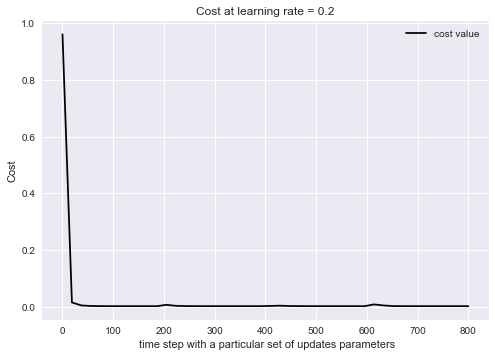

In [201]:
x=np.linspace(0,800,44)
y=arr1
plt.style.use("seaborn")
plt.plot(x,y,"black",label="cost value")
plt.title("Cost at learning rate = 0.2")
plt.ylabel("Cost")
plt.xlabel(" time step with a particular set of updates parameters")
plt.legend()
plt.show()

In [149]:
get_unitary(params)[2][2].real

tensor(0.99819335, requires_grad=True)

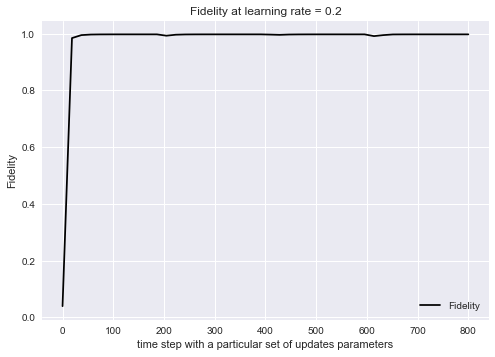

In [202]:
fidelity=[]
for elements in arr1:
    fidelity.append(1-elements)
    
fidelity
x=np.linspace(0,800,44)
y=fidelity
plt.plot(x,y,"black",label="Fidelity")
plt.title("Fidelity at learning rate = 0.2")
plt.ylabel("Fidelity")
plt.xlabel("time step with a particular set of updates parameters")
plt.legend()
plt.show()

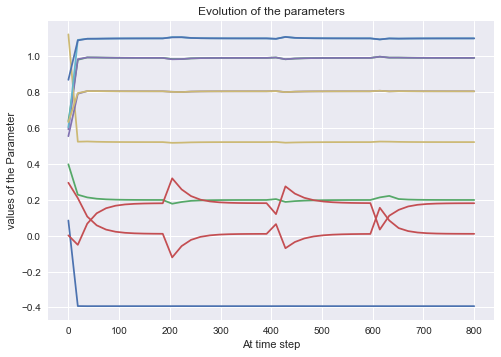

In [203]:
x=np.linspace(0,800,44)
y=arr2
plt.plot(x,y)
plt.ylabel("values of the Parameter")
plt.xlabel("At time step")
plt.title("Evolution of the parameters")
plt.legend()
plt.show()

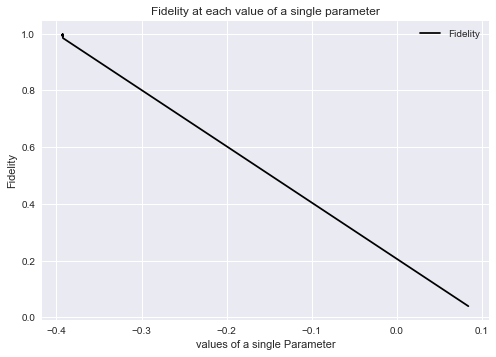

In [204]:
single_param=[]
for i in range(44):
    single_param.append(arr2[i][0])
x=single_param
y=fidelity
plt.plot(x,y,"black",label="Fidelity")
plt.xlabel("values of a single Parameter")
plt.ylabel("Fidelity")
plt.title("Fidelity at each value of a single parameter")
plt.legend()
plt.show()

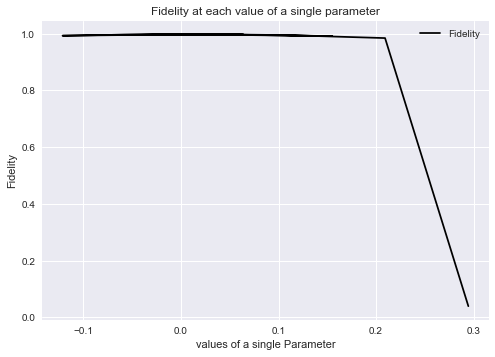

In [211]:
single_param=[]
for i in range(44):
    single_param.append(arr2[i][2])
x=single_param
y=fidelity
plt.plot(x,y,"black",label="Fidelity")
plt.xlabel("values of a single Parameter")
plt.ylabel("Fidelity")
plt.title("Fidelity at each value of a single parameter")
plt.legend()
plt.show()

In [154]:
circuit.draw()

' 0: ──╭|1⟩──╭C────────────╭C──────────────────────────╭C────────────╭C──RZ(0.521)──H──╭C───────────╭C──H──H──╭C───────────╭C──H─────────────────────────────────────────────────────────────────────────────╭C────────────╭C──────────────────────────╭C────────────╭C──RZ(0.521)──H──╭C───────────╭C──H──H──╭C───────────╭C──H─────────────────────────────────────────────────────────────────────────────╭C────────────╭C──────────────────────────╭C────────────╭C──RZ(0.521)──H──╭C───────────╭C──H──H──╭C───────────╭C──H─────────────────────────────────────────────────────────────────────────────╭C────────────╭C──────────────────────────╭C────────────╭C──RZ(0.521)──H──╭C───────────╭C──H──H──╭C───────────╭C──H─────────────────────────────────────────────────────────────────────────────╭C────────────╭C──────────────────────────╭C────────────╭C──RZ(0.521)──H──╭C───────────╭C──H──H──╭C───────────╭C──H─────────────────────────────────────────────────────────────────────────────╭C────────────╭C───────────